# Perform a climate change impact study on the hydrology of a watershed

Hydrological models typically need geographical information about watersheds being simulated: latitude and longitude, area, mean altitude, land-use, etc. This notebook shows how to obtain this information using remote services that are made available for users in PAVICS-Hydro. These services connect to a digital elevation model (DEM) and a land-use data set to extract relevant information.

The DEM used in the following is the [EarthEnv-DEM90](https://www.earthenv.org/DEM), while the land-use dataset is the [North American Land Change Monitoring System](http://www.cec.org/north-american-environmental-atlas/land-cover-30m-2015-landsat-and-rapideye/). Other data sources could be used, given their availability through the Web Coverage Service (WCS) protocol.

Since these computations happen on a specific Geoserver hosted in PAVICS, we need to establish a connection to that service. While the steps are a bit more complex, the good news is that you only need to change a few items in this notebook to taylor results to your needs.

We will also setup a hydrological model, calibrate it, and use it in evaluating the impacts of climate change on the hydrology of a catchment. We will be using the Mistassini river as the test-case for this example, but you can substitute the data for any catchment of your liking. We provide:

1- Streamflow observations (Water Survey Canada station 02RD003)

2- Watershed boundaries in the form of shapefiles (all shape files .shp, .shx, .prj, .dbf, etc. zipped into a single file. The platform will detect and unzip the file to extract the required data)


The rest will be done by PAVICS-Hydro, including getting meteorological information from our ERA5 reanalysis database and climate change model data from CMIP hosted by PanGEO.

## Software setup

### Import the required packages for this notebook.
Note that since the notebook includes the entire process from data collection to climate change impact studies, there are a lot more packages required than usual.

In [1]:
# We need to import a few packages required to do the work:

import datetime as dt

# Basic system packages
import os
import tempfile
import warnings
from pathlib import Path


# Packages for data extraction on remote servers/filesystems
import fsspec
import gcsfs
import geopandas as gpd

# Packages for geographic processing
import intake
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rioxarray as rio
import s3fs

# Packages related to ravenpy and hydrological modelling:
import spotpy
import xarray as xr

# Packages required for data processing
import xclim
import xclim.sdba as sdba
from birdy import WPSClient
from clisops.core import average, subset
from dask.diagnostics import ProgressBar

from ravenpy import Emulator
from ravenpy.config import commands as rc
from ravenpy.config.emulators import GR4JCN
from ravenpy.utilities.calibration import SpotSetup
from ravenpy.utilities.testdata import get_file

### Prepare some boilerplate items that will be required later on

In [2]:
# The platform provides lots of user warnings and information points. We will disable them for now.
warnings.filterwarnings("ignore")

# This is the URL of the Geoserver that will perform the computations for us.
url = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)

# Connect to the PAVICS-Hydro Raven WPS server to get the geospatial data from GeoServer
wps = WPSClient(url)

# Make a temporary path where the data will be stored and used by Raven
tmp = Path(tempfile.mkdtemp())

### Prepare datasets that will be required
This includes observed streamflow for the catchment of interest as well as the polygon/contour of that watershed. These could be gathered from CANOPEX, HYSETS or other databases, but we provide an example for user convenience here.

In [3]:
# Name of the watershed boundaries file that is uploaded to the server. Note that this file contains the
# .shx, .shp and other associated files for shapefiles, all zipped into one file. It will also be used later for
# extracting meteorological data.
basin_contour = get_file("paper/shapefile_basin_574_HYSETS.zip")

# This file is an extraction of streamflow for catchment 574 in HYSETS. Weather data will be gathered later from
# the ERA5 database, but could also be taken directly from HYSETS. This is to show how the process could be linked
# together for your own applications using ERA5 data.
streamflow_file = get_file("paper/Qobs_574_HYSETS.nc")

### Other user inputs of interest
We can also specify some information such as periods of interest for reference and future periods


In [4]:
# Reference period that will be used for ERA5 and climate model data for the reference period.
# Here let's focus on a 10-year period to keep running times lower.
reference_start_day = dt.datetime(1980, 12, 31)
reference_end_day = dt.datetime(1991, 1, 1)
# Notice we are using one day before and one day after the desired period of 1981-01-01 to 1990-12-31.
# This is to account for any UTC shifts that might require getting data in a previous or later time.

# Same process for the future period, 100 years later
future_start_day = dt.datetime(2080, 12, 31)
future_end_day = dt.datetime(2091, 1, 1)

## <span style="color:blue"> Geographic processing of watershed attributes</span>

Here we will use a set of tools to extract watershed properties that can be used for various applications. Not all variables we extract here are required for the hydrological modelling, but could be used for other applications.

,features,Name,OfficialID,FlagPAVICS,Source,Area,geometry
0,1,MISTASSINI (RIVIERE) EN AMONT DE LA RIVIERE MI...,02RD003,1,HYDAT,9870,"POLYGON ((-72.26250 48.87917, -72.27720 48.881..."


<Axes: >

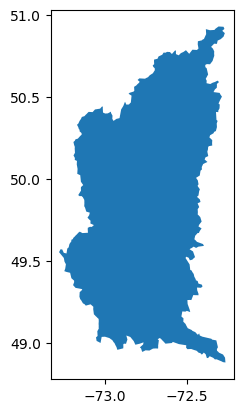

In [5]:
# Prepare a plot of the catchment to see what we are working with.
df = gpd.read_file(basin_contour)
display(df)
df.plot()

### Generic watershed properties

Now that we have delineated a watershed, lets find the zonal statistics and other properties using the `shape_properties` process. This process requires a `shape` argument defining the watershed contour, the exterior polygon.

Once the process has completed, we extract the data from the response, as follows. Note that you do not need to change anything here. The code will work and return the desired results.

In [6]:
shape_resp = wps.shape_properties(shape=basin_contour)

[
    properties,
] = shape_resp.get(asobj=True)
prop = properties[0]
display(prop)

area = prop["area"] / 1000000.0
longitude = prop["centroid"][0]
latitude = prop["centroid"][1]
gravelius = prop["gravelius"]
perimeter = prop["perimeter"]

shape_info = {
    "area": area,
    "longitude": longitude,
    "latitude": latitude,
    "gravelius": gravelius,
    "perimeter": perimeter,
}
display(shape_info)

{'id': '0',
 'features': 1,
 'Name': 'MISTASSINI (RIVIERE) EN AMONT DE LA RIVIERE MISTASSIBI',
 'OfficialID': '02RD003',
 'FlagPAVICS': 1,
 'Source': 'HYDAT',
 'Area': 9870,
 'area': 9569368968.087273,
 'centroid': [-72.7431067594341, 49.848278236356585],
 'perimeter': 727186.9587075961,
 'gravelius': 2.097005162538472}

{'area': 9569.368968087272,
 'longitude': -72.7431067594341,
 'latitude': 49.848278236356585,
 'gravelius': 2.097005162538472,
 'perimeter': 727186.9587075961}

Note that these properties are a mix of the properties of the original file where the shape is stored, and properties computed by the process (area, centroid, perimeter and gravelius). Note also that the computed area is in m², while the "SUB_AREA" property is in km², and that there are slight differences between the two values due to the precision of HydroSHEDS and the delineation algorithm.

### Land-use information

Now we extract the land-use properties of the watershed using the `nalcms_zonal_stats` process. As mentioned, it uses a dataset from the [North American Land Change Monitoring System](http://www.cec.org/north-american-environmental-atlas), and retrieve properties over the given region.

With the `nalcms_zonal_stats_raster` process, we also return the grid with variable accessors (`gdal`, `rasterio`, or `rioxarray`) depending on what libraries are available in our runtime environment (The following examples show `rioxarray`-like access).

In [7]:
stats_resp = wps.nalcms_zonal_stats_raster(
    shape=basin_contour, select_all_touching=True, band=1, simple_categories=True
)

Here we will get the raster data and compute statistics on it. It is also possible to download the extracted raseter offline (please see the tutorial for the steps on how to do this).

In [8]:
features, statistics, grid0 = stats_resp.get(asobj=True)
lu = statistics[0]
total = sum(lu.values())

land_use = {k: (v / total) for (k, v) in lu.items()}
display("Land use ratios", land_use)

land_use_pct = {k: f"{np.round(v/total*100, 2)} %" for (k, v) in lu.items()}
display("Land use percentages", land_use_pct)

'Land use ratios'

{'Ocean': 0.0,
 'Forest': 0.7246596208414477,
 'Shrubs': 0.14616312094792794,
 'Grass': 0.04322426804857576,
 'Wetland': 0.013300924493021603,
 'Crops': 0.00395034960218003,
 'Urban': 0.0035571063310866975,
 'Water': 0.06514460973576021,
 'SnowIce': 0.0}

'Land use percentages'

{'Ocean': '0.0 %',
 'Forest': '72.47 %',
 'Shrubs': '14.62 %',
 'Grass': '4.32 %',
 'Wetland': '1.33 %',
 'Crops': '0.4 %',
 'Urban': '0.36 %',
 'Water': '6.51 %',
 'SnowIce': '0.0 %'}

### Terrain information from the DEM

Here we collect terrain data, such as elevation, slope and aspect, from the DEM. We will do this using the `terrain_analysis` WPS service, which by default uses DEM data from [EarthEnv-DEM90](https://www.earthenv.org/DEM).

Note here that while the feature outline is defined above in terms of geographic coordinates (latitude, longitude), the DEM is projected onto a 2D cartesian coordinate system (here NAD83, the Canada Atlas Lambert projection). This is necessary to perform slope calculations. For more information on this, see: https://en.wikipedia.org/wiki/Map_projection

The DEM data returned in the process response here shows `rioxarray`-like access but using the URLs we can open the files however we like.

In [9]:
terrain_resp = wps.terrain_analysis(
    shape=basin_contour, select_all_touching=True, projected_crs=3978
)

properties, dem0 = terrain_resp.get(asobj=True)

elevation = properties[0]["elevation"]
slope = properties[0]["slope"]
aspect = properties[0]["aspect"]

terrain = {"elevation": elevation, "slope": slope, "aspect": aspect}
display(terrain)

{'elevation': 423.6657935442332,
 'slope': 3.949426174669343,
 'aspect': 148.55915312059147}

### Overview

A synthesis of all watershed properties can be created by merging the various dictionaries created. This allows users to easily access any of these values, and to provide them to a Raven model as needed.

In [10]:
all_properties = {**shape_info, **land_use, **terrain}
display(all_properties)

{'area': 9569.368968087272,
 'longitude': -72.7431067594341,
 'latitude': 49.848278236356585,
 'gravelius': 2.097005162538472,
 'perimeter': 727186.9587075961,
 'Ocean': 0.0,
 'Forest': 0.7246596208414477,
 'Shrubs': 0.14616312094792794,
 'Grass': 0.04322426804857576,
 'Wetland': 0.013300924493021603,
 'Crops': 0.00395034960218003,
 'Urban': 0.0035571063310866975,
 'Water': 0.06514460973576021,
 'SnowIce': 0.0,
 'elevation': 423.6657935442332,
 'slope': 3.949426174669343,
 'aspect': 148.55915312059147}

## <span style="color:blue">Getting meteorological and climate data</span>

Now that we have all the geographic information for our watershed, we can get the input meteorological data required to calibrate and run the model, as well as climate model data that will be used to perform a climate change impact study.

We start by using an in-house solution that keeps updated ERA5 reanalysis datasets available with little to no wait.

In [11]:
# Get the ERA5 data from the Wasabi/Amazon S3 server.
catalog_name = "https://raw.githubusercontent.com/hydrocloudservices/catalogs/main/catalogs/atmosphere.yaml"
cat = intake.open_catalog(catalog_name)
ds = cat.era5_reanalysis_single_levels.to_dask()

"""
Get the ERA5 data. We will rechunk it to a single chunck to make it compatible with other codes on the platform,
especially bias-correction. We are also taking the daily min and max temperatures as well as the daily total
precipitation.
"""
# We will add a wrapper to ensure that the following operations will preserve the original data attributes,
# such as units and variable names.
with xr.set_options(keep_attrs=True):
    ERA5_reference = subset.subset_shape(
        ds.sel(time=slice(reference_start_day, reference_end_day)), basin_contour
    )
    ERA5_tmin = ERA5_reference["t2m"].resample(time="1D").min().chunk(-1, -1, -1)
    ERA5_tmax = ERA5_reference["t2m"].resample(time="1D").max().chunk(-1, -1, -1)
    ERA5_pr = ERA5_reference["tp"].resample(time="1D").sum().chunk(-1, -1, -1)

    # Change the units
    ERA5_tmin = ERA5_tmin - 273.15  # K to °C
    ERA5_tmin.attrs["units"] = "degC"

    ERA5_tmax = ERA5_tmax - 273.15  # K to °C
    ERA5_tmax.attrs["units"] = "degC"

    ERA5_pr = ERA5_pr * 1000  # m to mm
    ERA5_pr.attrs["units"] = "mm"

    # Average the variables spatially
    ERA5_tmin = ERA5_tmin.mean({"latitude", "longitude"})
    ERA5_tmax = ERA5_tmax.mean({"latitude", "longitude"})
    ERA5_pr = ERA5_pr.mean({"latitude", "longitude"})

    # Ensure that the precipitation is non-negative, which can happen with some reanalysis models.
    ERA5_pr = np.maximum(ERA5_pr, 0)

    # Transform them to a dataset such that they can be written with attributes to netcdf
    ERA5_tmin = ERA5_tmin.to_dataset(name="tmin", promote_attrs=True)
    ERA5_tmax = ERA5_tmax.to_dataset(name="tmax", promote_attrs=True)
    ERA5_pr = ERA5_pr.to_dataset(name="pr", promote_attrs=True)

    # Write to disk. Here is where we write to disk and where the notebook will fail if running it from the
    # original location on the server (which is read-only). Please move the notebooks to your writable-workspace.
    ERA5_weather = xr.merge([ERA5_tmin, ERA5_tmax, ERA5_pr])
    ERA5_weather.to_netcdf(tmp / "ERA5_meteo_data.nc")

### We can now also get the climate model data

Use the connection to PanGEO to gather the CMIP6 model data for the MIROC6 model. Other models are available, as described in the tutorial Notebook "08 - Getting and Bias-Correcting CMIP6 data".

In [12]:
# Climate model to use
climate_model = "MIROC6"

# Get the catalog info from the pangeo dataset, which basically is a list of links to the various products.
fsCMIP = gcsfs.GCSFileSystem(token="anon", access="read_only")
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)

# We will add a wrapper to ensure that the following operations will preserve the original data attributes, such as units and variable names.
with xr.set_options(keep_attrs=True):
    # Load the files from the PanGEO catalogs, for reference and future variables of temperature and precipitation.
    out = {}
    for exp in ["historical", "ssp585"]:
        if exp == "historical":
            period_start = reference_start_day
            period_end = reference_end_day
        else:
            period_start = future_start_day
            period_end = future_end_day

        out[exp] = {}
        for variable in ["tasmin", "tasmax", "pr"]:
            print(exp, variable)
            query = dict(
                experiment_id=exp,
                table_id="day",
                variable_id=variable,
                member_id="r1i1p1f1",
                source_id=climate_model,
            )
            col_subset = col.search(require_all_on=["source_id"], **query)
            mapper = fsCMIP.get_mapper(col_subset.df.zstore[0])
            
            ds = xr.open_zarr(mapper, consolidated=True).sel(
                        time=slice(period_start, period_end)
                    )
            
            if "height" in ds.coords:
                ds = ds.drop_vars("height")

            out[exp][variable] = average.average_shape(
                ds,
                basin_contour,
            )[variable].chunk(-1)
            

# We can now extract the variables that we will need later:
historical_tasmax = out["historical"]["tasmax"]
historical_tasmin = out["historical"]["tasmin"]
historical_pr = out["historical"]["pr"]
future_tasmax = out["ssp585"]["tasmax"]
future_tasmin = out["ssp585"]["tasmin"]
future_pr = out["ssp585"]["pr"]

historical tasmin
historical tasmax
historical pr
ssp585 tasmin
ssp585 tasmax
ssp585 pr


### Change units

Climate models and reanalysis datasets have often differing units to those expected by Raven. Here we update units to make them compatible

In [13]:
# Here we need to make sure that our units are all in the correct format. You can play around with the tools we've seen thus far to explore the units
# and make sure everything is consistent.

# Let's start with precipitation:
# The CMIP data is a rate rather than an absolute value, so let's get the absolute values:
historical_pr = xclim.core.units.rate2amount(historical_pr)
future_pr = xclim.core.units.rate2amount(future_pr)

# Now we can actually convert units in absolute terms.
historical_pr = xclim.core.units.convert_units_to(historical_pr, "mm", context="hydro")
future_pr = xclim.core.units.convert_units_to(future_pr, "mm", context="hydro")

# Now let's do temperature:
historical_tasmin = xclim.core.units.convert_units_to(historical_tasmin, "degC")
historical_tasmax = xclim.core.units.convert_units_to(historical_tasmax, "degC")
future_tasmin = xclim.core.units.convert_units_to(future_tasmin, "degC")
future_tasmax = xclim.core.units.convert_units_to(future_tasmax, "degC")

### Apply bias-correction to the climate model data

Here is where we perform the bias-correction to the reference and future climate data in order to remove biases as seen between the reference and historical data. The future dataset is then corrected with the same adjustment factors as those in the reference period. Feel free to modify the bias-correction method, quantiles, etc.

In [14]:
# Use xclim utilities (sbda) to give information on the type of window used for the bias correction.
group_month_window = sdba.utils.Grouper("time.dayofyear", window=15)

# This is an adjusting function. It builds the tool that will perform the corrections.
Adjustment = sdba.DetrendedQuantileMapping.train(
    ref=ERA5_weather.pr,
    hist=historical_pr,
    nquantiles=50,
    kind="+",
    group=group_month_window,
)

# Apply the correction factors on the reference period
corrected_ref_precip = Adjustment.adjust(historical_pr, interp="linear")

# Apply the correction factors on the future period
corrected_fut_precip = Adjustment.adjust(future_pr, interp="linear")

# Ensure that the precipitation is non-negative, which can happen with some climate models
corrected_ref_precip = corrected_ref_precip.where(corrected_ref_precip > 0, 0)
corrected_fut_precip = corrected_fut_precip.where(corrected_fut_precip > 0, 0)

# Train the model to find the correction factors for the maximum temperature (tasmax) data
Adjustment = sdba.DetrendedQuantileMapping.train(
    ref=ERA5_weather.tmax,
    hist=historical_tasmax,
    nquantiles=50,
    kind="+",
    group=group_month_window,
)

# Apply the correction factors on the reference period
corrected_ref_tasmax = Adjustment.adjust(historical_tasmax, interp="linear")

# Apply the correction factors on the future period
corrected_fut_tasmax = Adjustment.adjust(future_tasmax, interp="linear")

# Train the model to find the correction factors for the minimum temperature (tasmin) data
Adjustment = sdba.DetrendedQuantileMapping.train(
    ref=ERA5_weather.tmin,
    hist=historical_tasmin,
    nquantiles=50,
    kind="+",
    group=group_month_window,
)

# Apply the correction factors on the reference period
corrected_ref_tasmin = Adjustment.adjust(historical_tasmin, interp="linear")

# Apply the correction factors on the future period
corrected_fut_tasmin = Adjustment.adjust(future_tasmin, interp="linear")

### Generate the NetCDF files

Now that the datasets are created, we can generate files so that Raven can access them. This might take a bit of time since everything up until now has been done in a "lazy" framework by Python. Data processing is actually just now really starting.

In [15]:
# Convert the reference corrected data into netCDF file. We will then apply a special code to remove a dimension in the dataset to make it applicable to the RAVEN models.
ref_dataset = xr.merge(
    [
        corrected_ref_precip.to_dataset(name="pr"),
        corrected_ref_tasmax.to_dataset(name="tasmax"),
        corrected_ref_tasmin.to_dataset(name="tasmin"),
    ]
)

# Write to temporary folder
fn_tmp_ref = tmp / "reference_dataset_tmp.nc"
ref_dataset.to_netcdf(fn_tmp_ref)

# Convert the future corrected data into netCDF file
fut_dataset = xr.merge(
    [
        corrected_fut_precip.to_dataset(name="pr"),
        corrected_fut_tasmax.to_dataset(name="tasmax"),
        corrected_fut_tasmin.to_dataset(name="tasmin"),
    ]
)
# Write to temporary folder
with ProgressBar():
    fn_tmp_fut = tmp / "future_dataset_tmp.nc"
    fut_dataset.to_netcdf(fn_tmp_fut)

    # Write the data to disk to a temporary location for future use.
    ref_dataset = xr.open_dataset(fn_tmp_ref)
    ref_dataset.isel(geom=0).squeeze().to_netcdf(tmp / "reference_dataset.nc")

    fut_dataset = xr.open_dataset(fn_tmp_fut)
    fut_dataset.isel(geom=0).squeeze().to_netcdf(tmp / "future_dataset.nc")


[########################################] | 100% Completed | 101.67 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 100.84 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 100.86 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 101.22 ms
[########################################] | 100% Completed | 101.03 ms
[########################################] | 100% Completed | 44.71 ss


## <span style="color:blue"> Set-up the hydrological model </span>

Now that we have geographic and meteorological input data available, we can setup a Raven hydrological model and calibrate it. Many more details can be found in the documentation and tutorial notebooks.

Start by setting up the configuration for the GR4JCN hydrological model we will use in this example.

In [16]:
# Define the hydrological response unit. We can use the geographic information we gathered previously to
# populate the fields for the HRU.
hru = {}
hru = dict(
    area=all_properties["area"],
    elevation=all_properties["elevation"],
    latitude=all_properties["latitude"],
    longitude=all_properties["longitude"],
    hru_type="land",
)

# Establish the start date for the calibration. This is set in the model configuration, so the calibrator
# will simply execute the model which has been pre-configured to run on this period.
start_date = dt.datetime(1981, 1, 1)
end_date = dt.datetime(1985, 12, 31)

# The data types available in the forcing netcdf file from ERA5, as per the tutorials.
data_type = ["TEMP_MAX", "TEMP_MIN", "PRECIP"]

# Alternative variable names as described in the tutorial.
alt_names = {
    "TEMP_MIN": "tmin",
    "TEMP_MAX": "tmax",
    "PRECIP": "pr",
}

# The data keywords necessary to indicate the elevation, latitude and longitude of the ERA5 forcing data. Here
# we use the information for the basin average as the ERA5 data is averaged on the watershed.
data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "latitude": hru["latitude"],
        "longitude": hru["longitude"],
    }
}

# Give a name to the simulation
run_name = "Paper_example_simulation"

# Setup the gauge object that includes meteorological data from ERA5
gauge = [
    rc.Gauge.from_nc(
        tmp
        / "ERA5_meteo_data.nc",  # Path to the ERA5 file containing all three meteorological variables
        data_type=data_type,  # Note that this is the list of all the variables
        alt_names=alt_names,  # Note that all variables here are mapped to their names in the netcdf file.
        data_kwds=data_kwds,
    )
]

# Read the streamflow from the HYSETS catchment data for this basin
discharge_data = [rc.ObservationData.from_nc(streamflow_file, alt_names="discharge")]

# Which evaluation metric do we want to use for calibration. Raven will return this by default after each run,
# and the optimizer will read it directly to calibrate.
eval_metrics = ("NASH_SUTCLIFFE",)

# Build the model configuration according to user preferences and inputs
model_config = GR4JCN(
    ObservationData=discharge_data,
    Gauge=gauge,
    HRUs=[hru],
    StartDate=start_date,
    EndDate=end_date,
    RunName=run_name,
    EvaluationMetrics=eval_metrics,  # We add this code to tell Raven which objective function we want to pass.
    SuppressOutput=True,  # This stops Raven from generating the output .nc files at each iteration.
)

### Hydrological model calibration

We have finished building the model configuration. We can now focus on the optimizer itself!

In [17]:
# In order to calibrate your model, you need to give the lower and higher bounds of the model. In this case,
# we are passing the boundaries for a GR4JCN, but it's important to change them, if you are using another model.
low = (0.01, -15.0, 10.0, 0.0, 1.0, 0.0)
high = (2.5, 10.0, 700.0, 7.0, 30.0, 1.0)

# Random seed. We will provide one for consistency purposes, but operationnaly this should not be provided.
random_seed = 42
np.random.seed(random_seed)

# Build the optimizer object
spot_setup = SpotSetup(
    config=model_config,
    low=low,
    high=high,
)

# Maximum number of model evaluations. We only use 200 here to keep the computation time as low as possible,
# but you will want to increase this for operational use, perhaps to 2000-5000 depending on the model.
max_iterations = 200

# Setup the spotpy sampler with the method, the setup configuration, a run name and other options. Please refer
# to the spotpy documentation for more options. We recommend sticking to this format for efficiency of most
# applications. Here we use DDS as the optimization algorithm. More are available: see the Spotpy documentation
# for more information. Here, DDS is used as it is powerful and particularly useful for optimizations with small
# evaluation budgets. For more details on DDS, see:
#
# Tolson, B.A. and Shoemaker, C.A., 2007. Dynamically dimensioned search algorithm for computationally efficient watershed model calibration. Water
# Resources Research, 43(1)
sampler = spotpy.algorithms.dds(
    spot_setup, dbname="RAVEN_model_run", dbformat="ram", save_sim=False
)

# Launch the actual optimization. Multiple trials can be launched, where the entire process is repeated and
# the best overall value from all trials is returned.
sampler.sample(max_iterations, trials=1)

# Get the model diagnostics
diag = spot_setup.diagnostics

# Get all the values of each iteration
results = sampler.getdata()

# Get the raw resutlts directly in an array
bestindex, bestobjfun = spotpy.analyser.get_maxlikeindex(
    results
)  # Want to get the MAX NSE (change for min for RMSE)
best_model_run = list(
    results[bestindex][0]
)  # Get the parameter set returning the best NSE
optimized_parameters = best_model_run[
    1:-1
]  # Remove the NSE value (position 0) and the ID at the last position to get the actual parameter set.

# Display the parameter set ready to use in a future run:
print(optimized_parameters)

Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  200  repetitions
The objective function will be maximized
Starting the DDS algotrithm with 200 repetitions...
Finding best starting point for trial 1 using 5 random samples.
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
41 of 200, maximal objective function=0.513714, time remaining: 00:00:08
82 of 200, maximal objective function=0.563485, time remaining: 00:00:06
122 of 200, maximal objective function=0.582534, time remaining: 00:00:04
161 of 200, maximal objective function=0.625077, time remaining: 00:00:02
Best solution found has obj function value of 0.626782 at 5



*** Final SPOTPY summary ***
Total Duration: 9.95 seconds
Total Repetitions: 200
Maximal objective value: 0.626782
Corresponding parameter setting:
GR4J_X1: 0.604489
GR4J_X2: 5.43047
GR4J_X3: 260.868
GR4J_X4: 6.33189
CEMANEIGE_X1: 15.9962
CEMANEIGE_X2: 0.816799
******************************

Run number 198 has the highest

### Run the calibrated hydrological model on a validation period

Now that the hydrological model has been calibrated, we can use these parameters to run the model on an independent period for validation, using ERA5 as the observation weather dataset.

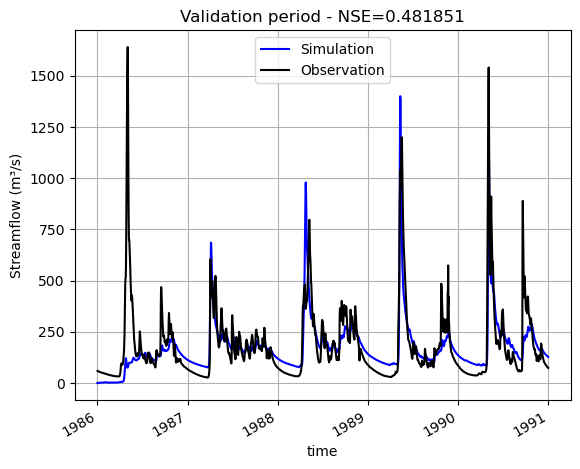

In [19]:
# Copy the configuration of the previous model that we will modify for our validation:
model_validation = model_config.duplicate(
    StartDate=dt.datetime(1986, 1, 1),
    EndDate=dt.datetime(1990, 12, 31),
    SuppressOutput=False,
).set_params(optimized_parameters)

sim_output = Emulator(config=model_validation).run()

# Get validation NSE (note we are counting the first year without warm-up)
NSE = sim_output.diagnostics["DIAG_NASH_SUTCLIFFE"]

# Plot the model output
sim_output.hydrograph.q_sim.plot(color="blue", label="Simulation")
sim_output.hydrograph.q_obs.plot(color="black", label="Observation")
plt.legend()
plt.title("Validation period - NSE=" + str(NSE[0]))
plt.ylabel("Streamflow (m³/s)")
plt.grid()
plt.show()

## <span style="color:blue">Climate change impacts on hydrology</span>

We can now run GR4JCN to obtain streamflow using the climate model data. We will run the calibrated hydrological model with reference and future data and compare results.

### Reference period simulation

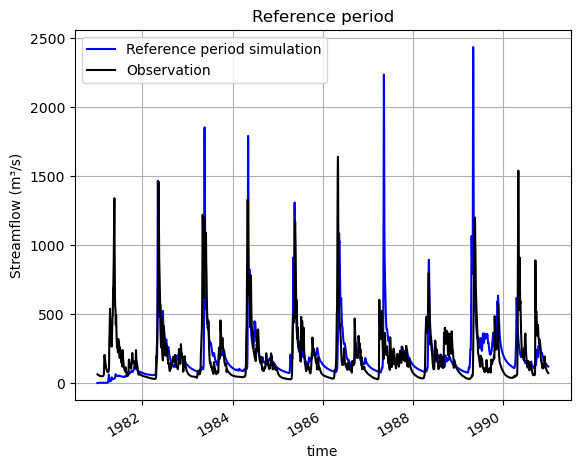

In [20]:
# Setup a gauge for Raven to read-in the reference climate data, just like for ERA5
gauge_ref = [
    rc.Gauge.from_nc(
        tmp
        / "reference_dataset.nc",  # Path to the CMIP6 model reference data netcdf file
        data_type=data_type,
        alt_names=alt_names,
        data_kwds=data_kwds,
    )
]

# Copy the configuration of the previous model that we will modify for our simulation on the reference period.
model_config_reference = model_validation.duplicate(
    Gauge=gauge_ref,
    StartDate=reference_start_day
    + dt.timedelta(days=1),  # Add a day here to account for the UTC lag in ERA5
    EndDate=reference_end_day,
)

# Run the model from the configuration and get the outputs.
ref_output = Emulator(config=model_config_reference).run()

# Plot the model output. Note that both simulations should have similar hydrological
# regime but day-to-day variability is not expected to match.
ref_output.hydrograph.q_sim.plot(color="blue", label="Reference period simulation")
ref_output.hydrograph.q_obs.plot(color="black", label="Observation")
plt.legend()
plt.title("Reference period")
plt.ylabel("Streamflow (m³/s)")
plt.grid()
plt.show()

### Future period simulation

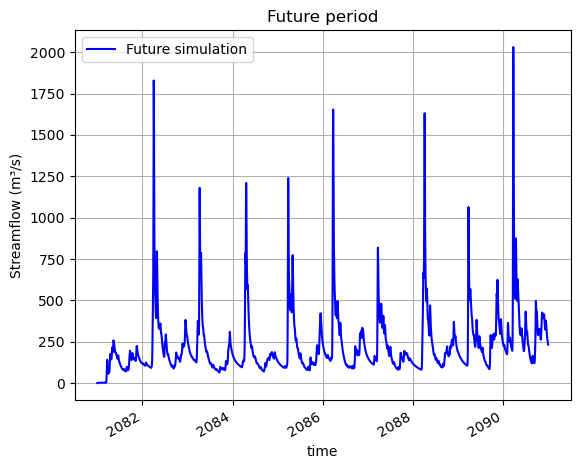

In [21]:
# Setup a gauge for Raven to read-in the future climate data, just like for the reference data
gauge_fut = [
    rc.Gauge.from_nc(
        tmp / "future_dataset.nc",  # Path to the CMIP6 model reference data netcdf file
        data_type=data_type,
        alt_names=alt_names,
        data_kwds=data_kwds,
    )
]

# Copy the configuration of the previous model that we will modify for our simulation on the reference period.
model_config_future = model_validation.duplicate(
    Gauge=gauge_fut,
    StartDate=future_start_day + dt.timedelta(days=1),
    EndDate=future_end_day,
    ObservationData=None,  # There are no observations for the future period.
)

# Run the model and get the outputs and hydrographs.
fut_output = Emulator(config=model_config_future).run()

# Plot the model output
fut_output.hydrograph.q_sim.plot(color="blue", label="Future simulation")
plt.legend()
plt.title("Future period")
plt.ylabel("Streamflow (m³/s)")
plt.grid()
plt.show()

### Compare results
We can now compare the results between:
- The observed flows;
- The simulation flows on the validation period;;
- The reference period flows;
- The future period flows.

Results cannot be compared on a day-to-day basis because climate models do not reflect actual weather data. Therefore, we will compare the mean annual hydrographs to see changes in long-term flow patterns. Note that this test only uses 10 years (5 for the validation period) which is insufficient. Operational tests should include more years (ideally 30 or more) to reflect the climatology of the various periods.


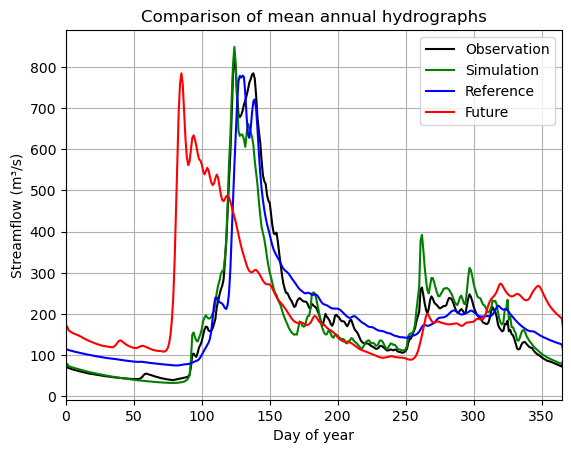

In [22]:
# Extract the mean annual hydrograph for each simulation.
observed_flows = ref_output.hydrograph.q_obs.groupby("time.dayofyear").mean()
simulated_flows = sim_output.hydrograph.q_obs.groupby("time.dayofyear").mean()
reference_flows = ref_output.hydrograph.q_sim.groupby("time.dayofyear").mean()
future_flows = fut_output.hydrograph.q_sim.groupby("time.dayofyear").mean()

# Plot the model output
observed_flows.plot(color="black", label="Observation", x="dayofyear")
simulated_flows.plot(color="green", label="Simulation", x="dayofyear")
reference_flows.plot(color="blue", label="Reference", x="dayofyear")
future_flows.plot(color="red", label="Future", x="dayofyear")
plt.legend()
plt.ylabel("Streamflow (m³/s)")
plt.xlabel("Day of year")
plt.xlim([0, 365])
plt.title("Comparison of mean annual hydrographs")
plt.grid()
plt.show()

We can see that the simulation and reference period flows are similar to the observations, whereas the future flows show a hastening of the springmelt along with higher winter flows.

Hydrographs could also be analysed using the tools shown in the "Time-series analysis" notebook.
